First, let's instanciate all components

In [1]:
from signreader.engine.text import TextReader
from signreader.engine.sign import SignDetector
from signreader.engine.symbol import SymbolDetector

textreader = TextReader()
signdetector = SignDetector()
symbdetector = SymbolDetector()



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.10.16 
torch version:  	2.7.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




Then, load an image:

In [2]:
from PIL import Image
import numpy as np

#fname_img = '/Users/manu/boulot/unit_solutions/data/datasets/segmentation/cellpose/test/48173-1_2.jpg' # example with no duration
fname_img = '/Users/manu/boulot/unit_solutions/data/datasets/segmentation/cellpose/test/48159-1_2.jpg'

img_pil = Image.open(fname_img)
img_np = np.asarray(img_pil)

Detect the signs:

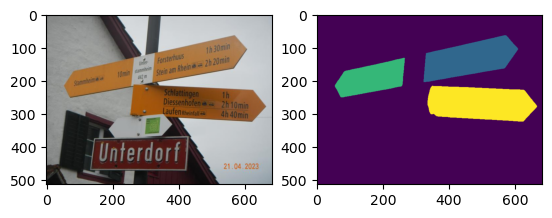

In [3]:
masks = signdetector(img_np)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(img_np)
axes[1].imshow(masks)

..Now, let's analyze each individual sign. First, use the mask to focus on considered sign:

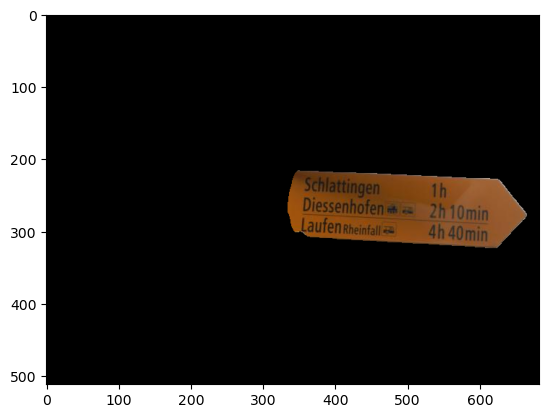

In [30]:
idx_list_signs = np.unique(masks)[1:] # first element is '0' and stands for background -> ignore

idx_signs = 3 # SELECT SIGN HERE
mask_sign = masks==idx_signs

img_np_focus = np.zeros(img_np.shape, dtype=np.uint8)
for channel in range(3):
    img_np_focus[:,:,channel] = img_np[:,:,channel] * mask_sign

fig, axes = plt.subplots(1,1)
axes.imshow(img_np_focus)

Now, let's detect text:

In [39]:
img_pil_focus = Image.fromarray(img_np_focus, 'RGB')
scontent = textreader(img_pil_focus)
print(scontent)

[{'destination': ' Schlattingen', 'duration': ' 1h', 'pos_dest': (502.2451171875, 270.0), 'pos_dura': (543.5986328125, 243.5)}, {'destination': ' Diessenhofen', 'duration': ' 2h 10min', 'pos_dest': (418.2041015625, 267.0), 'pos_dura': (572.279296875, 274.0)}, {'destination': ' Laufen', 'duration': ' 4h 40min', 'pos_dest': (497.576171875, 304.0), 'pos_dura': (568.27734375, 301.5)}]


Next, detect symbols:

In [32]:
boxes, class_names = symbdetector(img_np_focus)


0: 1920x2560 1 bahnhof, 1 bushof, 1 strassenbahn, 2622.9ms
Speed: 129.5ms preprocess, 2622.9ms inference, 8.3ms postprocess per image at shape (1, 3, 1920, 2560)


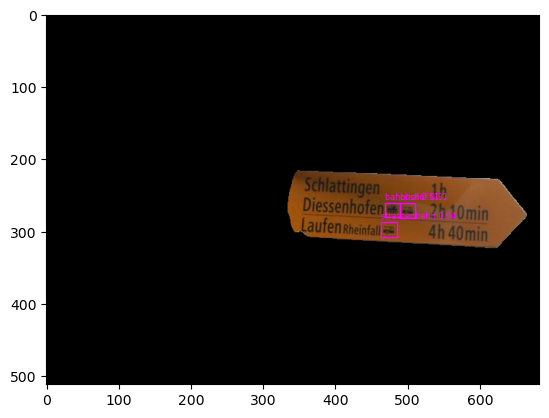

In [33]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1,1)
ax.imshow(img_np_focus)

for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0]
    confidence = float(box.conf[0])
    class_id = int(box.cls[0])
    label = class_names[class_id]

    # Ajouter une boîte rectangle
    width, height = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1, edgecolor='magenta', facecolor='none')
    ax.add_patch(rect)

    # Ajouter le texte (label + score)
    text = f"{label} {confidence:.2f}"
    ax.text(x1, y1 - 5, text,
        color='magenta',
        fontsize='xx-small')

Save data for prototyping_are_elements_on_same_line.ipynb

In [40]:
path_out = '/Users/manu/boulot/unit_solutions/data/toy_data/are_detections_on_same_line/'

import pickle
with open(path_out + "scontent.pkl", "wb") as f:
    pickle.dump(scontent, f)

with open(path_out + "boxes.pkl", "wb") as f:
    pickle.dump(boxes, f)

with open(path_out + "masks.pkl", "wb") as f:
    pickle.dump(masks, f)

img_pil_focus.save(path_out + "img_pil_focus.jpg")

Thanks to prototyping_are_elements_on_same_line.ipynb we now have functions distance_btw_point_and_line and get_lines_for_boxes. Nice!

We want to add a key to lcontent: lcontent['symbols'] = [class_lbl_1, class_lbl_2, ...]

In [41]:
import signreader.utils.analysis as analysis

idx_closest_line_per_box = analysis.get_lines_for_boxes(boxes=boxes, scontent=scontent)

for idx_line, lcontent in enumerate(scontent): # for each line in sign
    #idx_boxes = find(idx_closest_line_per_box==idx_line)
    idx_boxes = np.nonzero(np.array(idx_closest_line_per_box)==idx_line)[0] # [0] because outputs a tupple

    class_lbl_list = None  # default value
    if len(idx_boxes) > 0: # if for this line corresponding boxes have been found
        class_lbl_list = []
        for idx_box in idx_boxes:
            box = boxes[idx_box]
            class_lbl_list.append(int(box.cls[0]))

    lcontent['symbols'] = class_lbl_list
    scontent[idx_line] = lcontent

[{'destination': ' Schlattingen',
  'duration': ' 1h',
  'pos_dest': (502.2451171875, 270.0),
  'pos_dura': (543.5986328125, 243.5),
  'symbols': None},
 {'destination': ' Diessenhofen',
  'duration': ' 2h 10min',
  'pos_dest': (418.2041015625, 267.0),
  'pos_dura': (572.279296875, 274.0),
  'symbols': [1, 2]},
 {'destination': ' Laufen',
  'duration': ' 4h 40min',
  'pos_dest': (497.576171875, 304.0),
  'pos_dura': (568.27734375, 301.5),
  'symbols': [11]}]

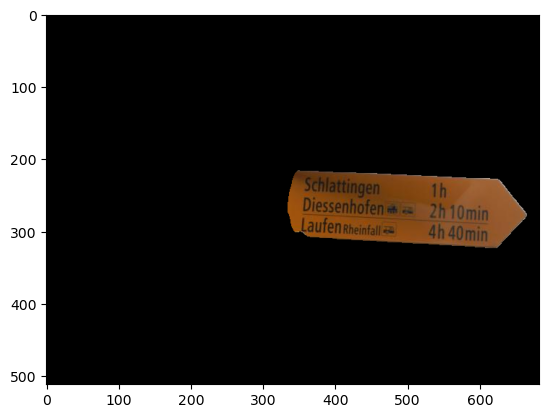

In [42]:
fig, ax = plt.subplots(1,1)
ax.imshow(img_np_focus)

scontent